# tRNA Example Using the iJL1678-ME ECOLIme Model: Isoleucine

## 1. Load the python packages

In [1]:
from __future__ import print_function, division, absolute_import

# python imports
import re
from os.path import join
from collections import defaultdict
import pickle
import pandas as pd

# third party imports
import pandas
import tabulate
import cobra
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',100)
pd.set_option('display.max_colwidth',100)

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
#from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/solvers/__init__.py:63: UserWarning: No LP solvers found
  warn("No LP solvers found")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


## 2. Load the iJL1678b model

Load the iJL1678b model in pickle format that is located in the current directory.

In [2]:
with open('iJL1678b.pickle', 'rb') as f:
    me = pickle.load(f)

## 3. Solve the model

In [3]:
def solve_me_model(me, max_mu, precision=1e-6, min_mu=0, using_soplex=False,
                  compiled_expressions=None):
    if using_soplex:
        from cobrame.solve.algorithms import binary_search
        binary_search(me, min_mu=min_mu, max_mu=max_mu, debug=True, mu_accuracy=precision,
                      compiled_expressions=compiled_expressions)
    else:
        from qminospy.me1 import ME_NLP1
        # The object containing solveME methods--composite that uses a ME model object 
        me_nlp = ME_NLP1(me, growth_key='mu')
        # Use bisection for now (until the NLP formulation is worked out)
        muopt, hs, xopt, cache = me_nlp.bisectmu(precision=precision, mumax=max_mu)
        me.solution.f = me.solution.x_dict['biomass_dilution']
        
def show_escher_map(me, solution=None):
    import escher
    view = escher.Builder("iJO1366.Central metabolism")
    view.reaction_data = me.get_metabolic_flux(solution=solution)
    return view

In [4]:
solve_me_model(me, 1., min_mu = .1, precision=1e-2, using_soplex=False)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 57.185298 seconds
Finished substituting S,lb,ub in 3.870224 seconds
Finished makeME_LP in 0.716018 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 4.319135 seconds
Finished makeME_LP in 0.755659 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 4.481188 seconds
Finished makeME_LP in 0.771832 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 4.326770 seconds
Finished makeME_LP in 0.717674 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 3.911795 seconds
Finished makeME_LP in 0.722161 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 3.920941 seconds
Finished makeME_LP in 0.717248 seconds
Getting MINOS pa

## 4. Modeling the iJL1678-ME ECOLIme Isoleucine tRNA Production Process

Let's begin by looking for the metabolites assoicated with isoleucine. This should include the isoleucine amino acid metabolites within the model including the version within the cytoplasm, periplasm and the extracellular space. It should also include the charged isoleucine tRNA metabolites required for the translation process.

Searching the model for "ile" related metabolites. 

In [5]:
me.metabolites.query('ile')

[<Metabolite ile__L_c at 0x7fccc62e9240>,
 <Metabolite ile__L_e at 0x7fccc707bd30>,
 <Metabolite ile__L_p at 0x7fccc44535c0>,
 <GenerictRNA generic_tRNA_AUC_ile__L_c at 0x7fccc62f89b0>,
 <GenerictRNA generic_tRNA_AUU_ile__L_c at 0x7fccc62f84e0>,
 <GenerictRNA generic_tRNA_AUA_ile__L_c at 0x7fccc62f8ef0>]

These results show three amino acid metabolites (ile__L_c, ile__L_p, ile__L_e) and three tRNA metabolites (generic_tRNA_AUC_ile__L_c, generic_tRNA_AUU_ile__L_c, generic_tRNA_AUA_ile__L_c). Each of the three tRNA metabolites are connected to the RNA codons that can produce isoleucine tRNA. The amino acid metabolites are produced by the isoleucine metabolic pathways while the tRNA metabolites are produced in separate tRNA pathways.

To understand isoleucine tRNA production let's begin with one of the charged isoleucine tRNA metabolites and work backwards to the gene that starts the production process. For this example we will focus on the production of the "generic_tRNA_AUC_ile__L_c" metabolite.

Finding the reactions that are associated with the AUC codon

In [6]:
me.reactions.query('AUC')

[<tRNAChargingReaction charging_tRNA_b0202_AUC at 0x7fccc2abdb00>,
 <tRNAChargingReaction charging_tRNA_b3277_AUC at 0x7fccc2a4ef28>,
 <tRNAChargingReaction charging_tRNA_b3852_AUC at 0x7fccc29de828>]

From these results we can see that the model has three different reactions that can produce the 'generic_tRNA_AUC_ile__L_c' metabolite. These correspond to

- charging_tRNA_b0202_AUC reaction: b0202, ileV or tRNA<sup>ileV</sup>, tRNA-Ile(anticodon = GAU)
- charging_tRNA_b3277_AUC reaction: b3277, ileU or tRNA<sup>ileU</sup>, tRNA-Ile(anticodon = GAU)
- charging_tRNA_b3852_AUC reaction: b3852, ileT or tRNA<sup>ileT</sup>, tRNA-Ile(anticodon = GAU)

For this example, let's identify and follow the reaction that carries flux

In [7]:
tRNA_b0202 = me.reactions.get_by_id('charging_tRNA_b0202_AUC').x
tRNA_b3277 = me.reactions.get_by_id('charging_tRNA_b3277_AUC').x
tRNA_b3852 = me.reactions.get_by_id('charging_tRNA_b3852_AUC').x

print(' charging_tRNA_b0202_AUC = ', tRNA_b0202, '\n', 'charging_tRNA_b3277_AUC = ', tRNA_b3277, '\n', 'charging_tRNA_b3852_AUC = ', tRNA_b3852)

 charging_tRNA_b0202_AUC =  0.0 
 charging_tRNA_b3277_AUC =  0.1419499892031561 
 charging_tRNA_b3852_AUC =  0.0


Thus, the active default active tRNA charging reaction is "charging_tRNA_b3277_AUC". Double checking we can see that this reaction does produce the "generic_tRNA_AUC_ile__L_c" metabolite.

In [8]:
me.reactions.get_by_id('charging_tRNA_b3277_AUC').products

[<GenerictRNA generic_tRNA_AUC_ile__L_c at 0x7fccc62f89b0>,
 <Metabolite h_c at 0x7fccc6fdbd30>,
 <Metabolite nadp_c at 0x7fccc2abdfd0>,
 <Metabolite amp_c at 0x7fccc70027b8>,
 <Metabolite h2o_c at 0x7fccc6fdba58>,
 <Metabolite ppi_c at 0x7fccc6fe40f0>,
 <Metabolite ahcys_c at 0x7fccc2ad14a8>,
 <Metabolite 5mta_c at 0x7fccc2ad14e0>]

Continuing to work backwards we can see what reactants required for this reaction.

In [9]:
me.reactions.get_by_id('charging_tRNA_b3277_AUC').reactants

[<TranscribedGene RNA_b3277 at 0x7fccc698f2b0>,
 <Metabolite ile__L_c at 0x7fccc62e9240>,
 <Complex IleS_mono_mod_2:zn2 at 0x7fccc2abdcc0>,
 <GenericComponent generic_Dus at 0x7fccc2abdcf8>,
 <Metabolite nadph_c at 0x7fccc2abddd8>,
 <Complex YrdC_mono at 0x7fccc2ad10b8>,
 <Metabolite hco3_c at 0x7fccc2ad10f0>,
 <Metabolite thr__L_c at 0x7fccc62dae48>,
 <Metabolite atp_c at 0x7fccc6fdb978>,
 <Complex YggH_mono at 0x7fccc2ad1278>,
 <Metabolite amet_c at 0x7fccc2ad12b0>,
 <Complex TrmA_mono at 0x7fccc2ad1550>,
 <Complex TruB_mono at 0x7fccc2ad1588>,
 <Complex YqcB_mono at 0x7fccc2ad15c0>]

At this point we have the following reactions and metabolites involved in the production of "generic_tRNA_AUC_ile__L_c"

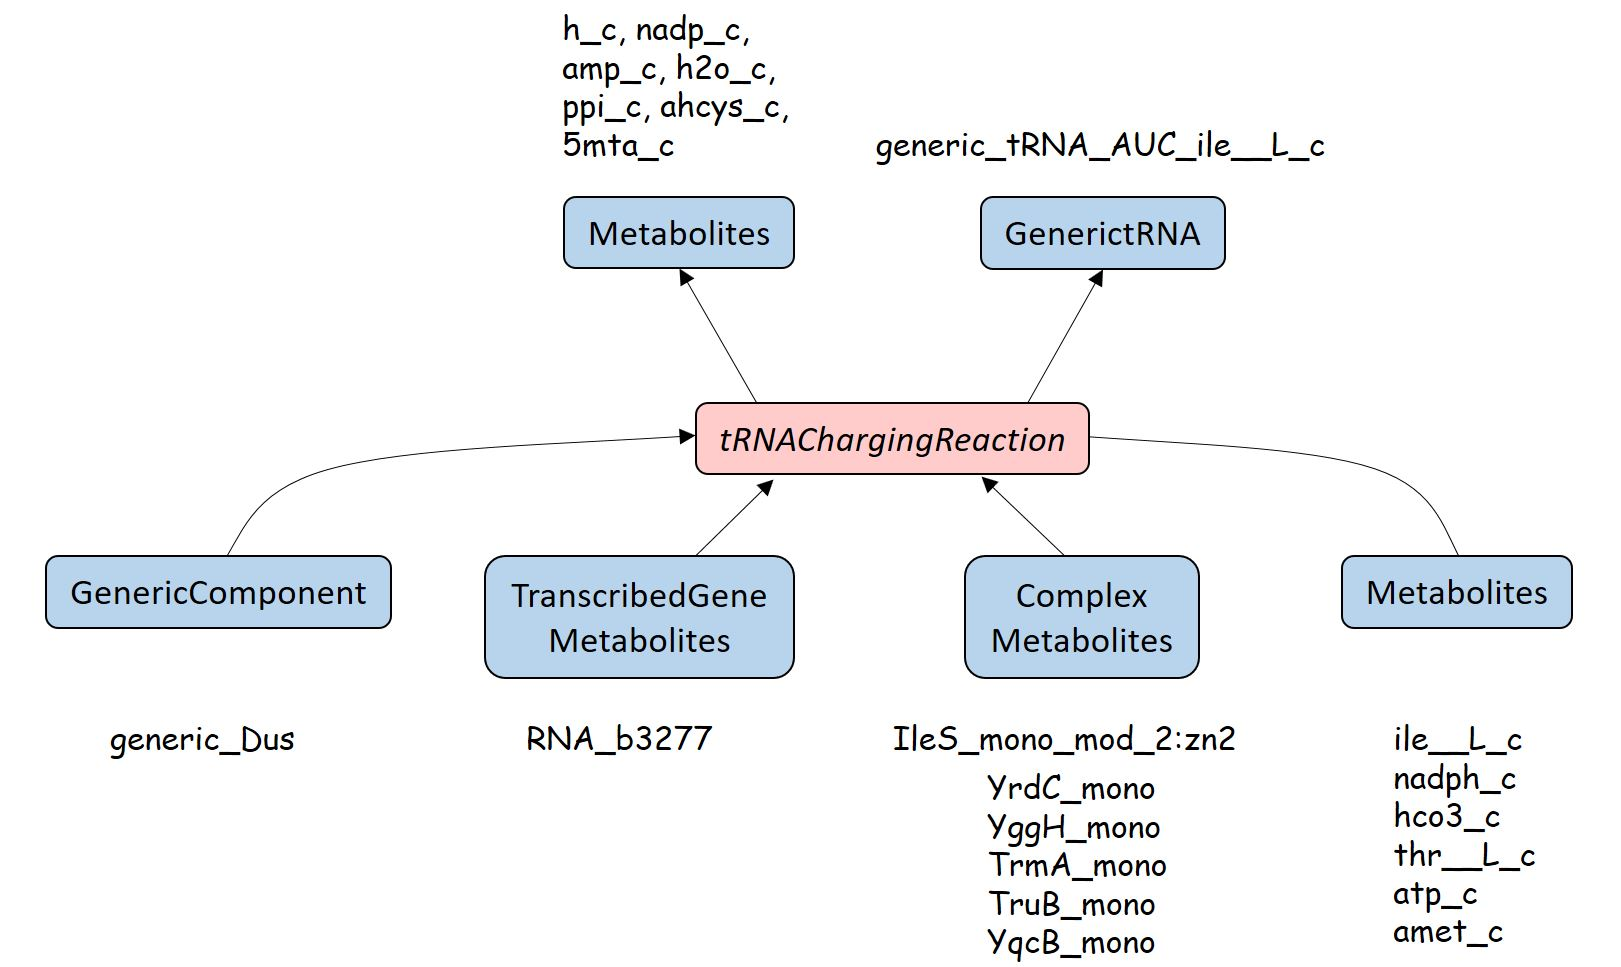

The "GenericComponent" and "Complex" metabolites are associated with the tRNA post-processing. tRNAs are processed to their active, mature forms by RNA cleavage and by modification of their bases. RNA cleavage consists of removal of both 5' and 3' extensions in a multistep process involving many Rnases. tRNAs are also subject to a wide variety of base modifications catalyzed by proteins

Let's now follow the pathways of the different reactants to the 'charging_tRNA_b3277_AUC' reactions

### 4.1 "TranscribedGene" Metabolites

The reactions that creates the 'RNA_b3277' metabolite can be found from the following data.

In [10]:
me.metabolites.get_by_id('RNA_b3277').reactions

frozenset({<MEReaction DM_RNA_b3277 at 0x7fccc28c7160>,
           <tRNAChargingReaction charging_tRNA_b3277_AUC at 0x7fccc2a4ef28>,
           <tRNAChargingReaction charging_tRNA_b3277_AUU at 0x7fccc29d70f0>,
           <TranscriptionReaction transcription_TU0_1191_from_RpoD_mono at 0x7fccc698f128>,
           <TranscriptionReaction transcription_TU0_1192_from_RpoD_mono at 0x7fccc6939d30>})

From this information we can assume that "DM_RNA_b3277" is the demand reaction for RNA dilution. The two "tRNAChargingReaction" reactions consume the metabolite while the two "transcriptionReaction" reactions can produce it.

Let's find out which one of the producing reactions is active in the default simulation.

In [11]:
TU0_1191 = me.reactions.get_by_id('transcription_TU0_1191_from_RpoD_mono').x
TU0_1192 = me.reactions.get_by_id('transcription_TU0_1192_from_RpoD_mono').x

print(' transcription_TU0_1191_from_RpoD_mono = ', TU0_1191, '\n', 'transcription_TU0_1192_from_RpoD_mono = ', TU0_1192)

 transcription_TU0_1191_from_RpoD_mono =  0.0 
 transcription_TU0_1192_from_RpoD_mono =  2.0576598941855087e-05


This identifies 'transcription_TU0_1192_from_RpoD_mono' as the active reaction that provides the transcription of the b3277 gene.

### 4.2 "Complex" Metabolites

The "Complex" metabolites provide some of the tRNA post-processing. The "Complex" reactions and their functions are

- IleS_mono_mod_2:zn2: b0026, ileS/ilvS/IleRS, isoleucine—tRNA ligase
- YrdC_mono: b3282, yrdC/tsaC/rimN, L-threonylcarbamoyladenylate synthase
- YggH_mono: b2960, yggH/trmB/trmI, tRNA m<sup>7</sup>G46 methyltransferase
- TrmA_mono: b3965, trmA/rT/rumT, tRNA m<sup>5</sup>U54 methyltransferase
- TruB_mono: b3166, truB/yhbA, tRNA pseudouridine<sup>55</sup> synthase
- YqcB_mono: b2791, yqcB/truC, tRNA pseudouridine<sup>65</sup> synthase

Let's follow the production pathways of a couple of these reactions. Let's start with the isoleucine—tRNA ligase reaction "IleS_mono_mod_2:zn2" and then we will explore the pathway of "YrdC_mono." The other reactions should have a similar production pathway to "YrdC_mono." 

#### 4.2.1 Isoleucine-tRNA ligase (IleRS) (IleS_mono_mod_2:zn2, b0026)

"Isoleucine-tRNA ligase (IleRS) is a member of the family of aminoacyl-tRNA synthetases, which interpret the genetic code by covalently linking amino acids to their specific tRNA molecules. The reaction is driven by ATP hydrolysis. IleRS belongs to the Class I aminoacyl tRNA synthetases" (https://www.ecocyc.org/gene?orgid=ECOLI&id=EG10492)

Finding the producing reaction of the "IleS_mono_mod_2:zn2" metabolite

In [12]:
me.metabolites.get_by_id('IleS_mono_mod_2:zn2').reactions

frozenset({<tRNAChargingReaction charging_tRNA_b0202_AUC at 0x7fccc2abdb00>,
           <tRNAChargingReaction charging_tRNA_b0202_AUU at 0x7fccc2ad1860>,
           <tRNAChargingReaction charging_tRNA_b2652_AUA at 0x7fccc2a3c4a8>,
           <tRNAChargingReaction charging_tRNA_b3069_AUA at 0x7fccc2a4e2b0>,
           <tRNAChargingReaction charging_tRNA_b3277_AUC at 0x7fccc2a4ef28>,
           <tRNAChargingReaction charging_tRNA_b3277_AUU at 0x7fccc29d70f0>,
           <tRNAChargingReaction charging_tRNA_b3852_AUC at 0x7fccc29de828>,
           <tRNAChargingReaction charging_tRNA_b3852_AUU at 0x7fccc29de9b0>,
           <ComplexFormation formation_IleS_mono_mod_2:zn2 at 0x7fccc239f940>})

The "tRNAChargingReaction" reactions are the consumers of the "IleS_mono_mod_2:zn2" metabolite while "formation_IleS_mono_mod_2:zn2" is the producing reaction. Looking at the products of this reaction.

In [13]:
me.reactions.get_by_id('formation_IleS_mono_mod_2:zn2').products

[<Constraint prosthetic_group_biomass at 0x7fccc70fc438>,
 <Complex IleS_mono_mod_2:zn2 at 0x7fccc2abdcc0>]

The product of the reaction is the assumed metabolites "IleS_mono_mod_2:zn2" The reaction also provides a prosthetic group biomass.

The reactants of this reaction are 

In [14]:
me.reactions.get_by_id('formation_IleS_mono_mod_2:zn2').reactants

[<TranslatedGene protein_b0026 at 0x7fccc6275c50>,
 <Metabolite zn2_c at 0x7fccc2513c88>]

The reactants include the translated protein from the gene for the isoleucine—tRNA ligase (b0026) and a zn<sup>2</sup> metabolite

In [15]:
me.reactions.get_by_id('formation_IleS_mono_mod_2:zn2').reaction

'protein_b0026 + 2.0 zn2_c --> IleS_mono_mod_2:zn2 + 0.13081800000000002 prosthetic_group_biomass'

In [16]:
me.metabolites.get_by_id('protein_b0026').reactions

frozenset({<ComplexFormation formation_IleS_mono_mod_2:zn2 at 0x7fccc239f940>,
           <TranslationReaction translation_b0026 at 0x7fccc6275780>})

#### 4.2.2 Threonylcarbamoyl-AMP synthase (YrdC_mono, b3282)

Threonylcarbamoyl-AMP synthase (TsaC or yrdC) catalyzes the synthesis of threonylcarbamoyl-AMP, an intermediate in the biosynthesis of the threonylcarbamoyladenosine (t<sup>6</sup>A) modification at position 37 of ANN-decoding tRNAs

Finding the producing reaction of the "YrdC_mono" metabolite

In [17]:
me.metabolites.get_by_id('YrdC_mono').reactions

frozenset({<tRNAChargingReaction charging_tRNA_b0202_AUC at 0x7fccc2abdb00>,
           <tRNAChargingReaction charging_tRNA_b0202_AUU at 0x7fccc2ad1860>,
           <tRNAChargingReaction charging_tRNA_b0244_ACG at 0x7fccc2a69240>,
           <tRNAChargingReaction charging_tRNA_b0536_AGA at 0x7fccc2a69550>,
           <tRNAChargingReaction charging_tRNA_b0666_AUG at 0x7fccc2a740b8>,
           <tRNAChargingReaction charging_tRNA_b0673_AUG at 0x7fccc2a74d68>,
           <tRNAChargingReaction charging_tRNA_b0743_AAA at 0x7fccc2a74f60>,
           <tRNAChargingReaction charging_tRNA_b0743_AAG at 0x7fccc2a7f470>,
           <tRNAChargingReaction charging_tRNA_b0745_AAA at 0x7fccc2a7fa58>,
           <tRNAChargingReaction charging_tRNA_b0745_AAG at 0x7fccc2a7fc50>,
           <tRNAChargingReaction charging_tRNA_b0747_AAA at 0x7fccc2a88080>,
           <tRNAChargingReaction charging_tRNA_b0747_AAG at 0x7fccc2a88278>,
           <tRNAChargingReaction charging_tRNA_b0748_AAA at 0x7fccc2a88358>,

The "tRNAChargingReaction" reactions are the consumers of the "YrdC_mono" metabolite while "formation_YrdC_mono," a "ComplexFormation" reaction, is the producing reaction. Looking at the products of this reaction.

In [18]:
me.reactions.get_by_id('formation_YrdC_mono').products

[<Complex YrdC_mono at 0x7fccc2ad10b8>]

This result confirms that "formation_YrdC_mono" is the producer of the "YrdC_mono" metabolite.

The reactants are

In [19]:
me.reactions.get_by_id('formation_YrdC_mono').reactants

[<TranslatedGene protein_b3282 at 0x7fccc39fa710>]

The reactant to this reaction is the translated protein from the gene b3282.

The production pathways for the other "Complex" reactions can be found following a similar process.

## 4.3 "GenericComponent" Metabolites

This example has one "GenericComponent" reaction called "generic_Dus."

"DusA accounts for about half of the 5,6-dihydrouridine modification observed in wild-type cellular tRNA; DusB and DusC together account for the other half. DusA is solely responsible for the 5,6-dihydrouridine modification observed in tRNA<sub>2</sub><sup>fMet</sup> " (https://www.ecocyc.org/gene?orgid=ECOLI&id=EG11932)

In [20]:
me.metabolites.get_by_id('generic_Dus').reactions

frozenset({<GenericFormationReaction DusA_mono_to_generic_Dus at 0x7fccc0c0c6a0>,
           <GenericFormationReaction DusB_mono_to_generic_Dus at 0x7fccc0c0c710>,
           <GenericFormationReaction DusC_mono_to_generic_Dus at 0x7fccc0c0c780>,
           <tRNAChargingReaction charging_tRNA_b0202_AUC at 0x7fccc2abdb00>,
           <tRNAChargingReaction charging_tRNA_b0202_AUU at 0x7fccc2ad1860>,
           <tRNAChargingReaction charging_tRNA_b0203_GCA at 0x7fccc2ad1978>,
           <tRNAChargingReaction charging_tRNA_b0203_GCG at 0x7fccc2ad1e80>,
           <tRNAChargingReaction charging_tRNA_b0203_GCU at 0x7fccc2ad1f98>,
           <tRNAChargingReaction charging_tRNA_b0206_GAC at 0x7fccc2a5c0f0>,
           <tRNAChargingReaction charging_tRNA_b0206_GAU at 0x7fccc2a5ce10>,
           <tRNAChargingReaction charging_tRNA_b0216_GAC at 0x7fccc2a5cf28>,
           <tRNAChargingReaction charging_tRNA_b0216_GAU at 0x7fccc2a69160>,
           <tRNAChargingReaction charging_tRNA_b0244_ACG at 0

The "tRNAChargingReaction" reactions are the consumers of the "generic_Dus" metabolite while the following "GenericFormationReaction" reactions are the producing reactions.

- DusA_mono_to_generic_Dus
- DusB_mono_to_generic_Dus
- DusC_mono_to_generic_Dus

Let's find out which of these is active in the default model and carrying flux.

In [21]:
DusA = me.reactions.get_by_id('DusA_mono_to_generic_Dus').x
DusB = me.reactions.get_by_id('DusB_mono_to_generic_Dus').x
DusC = me.reactions.get_by_id('DusC_mono_to_generic_Dus').x

print(' DusA_mono_to_generic_Dus = ', DusA, '\n', 'DusB_mono_to_generic_Dus = ', DusB, '\n', 'DusC_mono_to_generic_Dus = ', DusC)

 DusA_mono_to_generic_Dus =  0.0 
 DusB_mono_to_generic_Dus =  0.0 
 DusC_mono_to_generic_Dus =  4.679154354088548e-09


Following the production pathway of "DusC_mono_to_generic_Dus" by looking at it's reactants.

In [22]:
me.reactions.get_by_id('DusA_mono_to_generic_Dus').reactants

[<Complex DusA_mono at 0x7fccc2791898>]

Now finding the reaction that produces "DusA_mono"

In [23]:
me.metabolites.get_by_id('DusA_mono').reactions

frozenset({<GenericFormationReaction DusA_mono_to_generic_Dus at 0x7fccc0c0c6a0>,
           <ComplexFormation formation_DusA_mono at 0x7fccc2791860>})

Knowing that the reaction "DusA_mono_to_generic_Dus" consumes "DusA_mono" we can assume that the "ComplexFormation" reaction produces the metabolite "formation_DusA_mono." This can be verified by looking at the products of this reaction.

In [24]:
me.reactions.get_by_id('formation_DusA_mono').products

[<Complex DusA_mono at 0x7fccc2791898>]

Now looking at the reactants of the reaction should identify the translated protein that is the foundation for the "generic_Dus" reaction.

In [25]:
me.reactions.get_by_id('formation_DusA_mono').reactants

[<TranslatedGene protein_b4049 at 0x7fccc2e88748>]

Thus, the translated protein "protein_b4049" leads to the b4049 gene that is the starting point for the "generic_Dus" reaction.

## 5. Conclusion

A detailed drawing of the production pathways for Isoleucine tRNA is

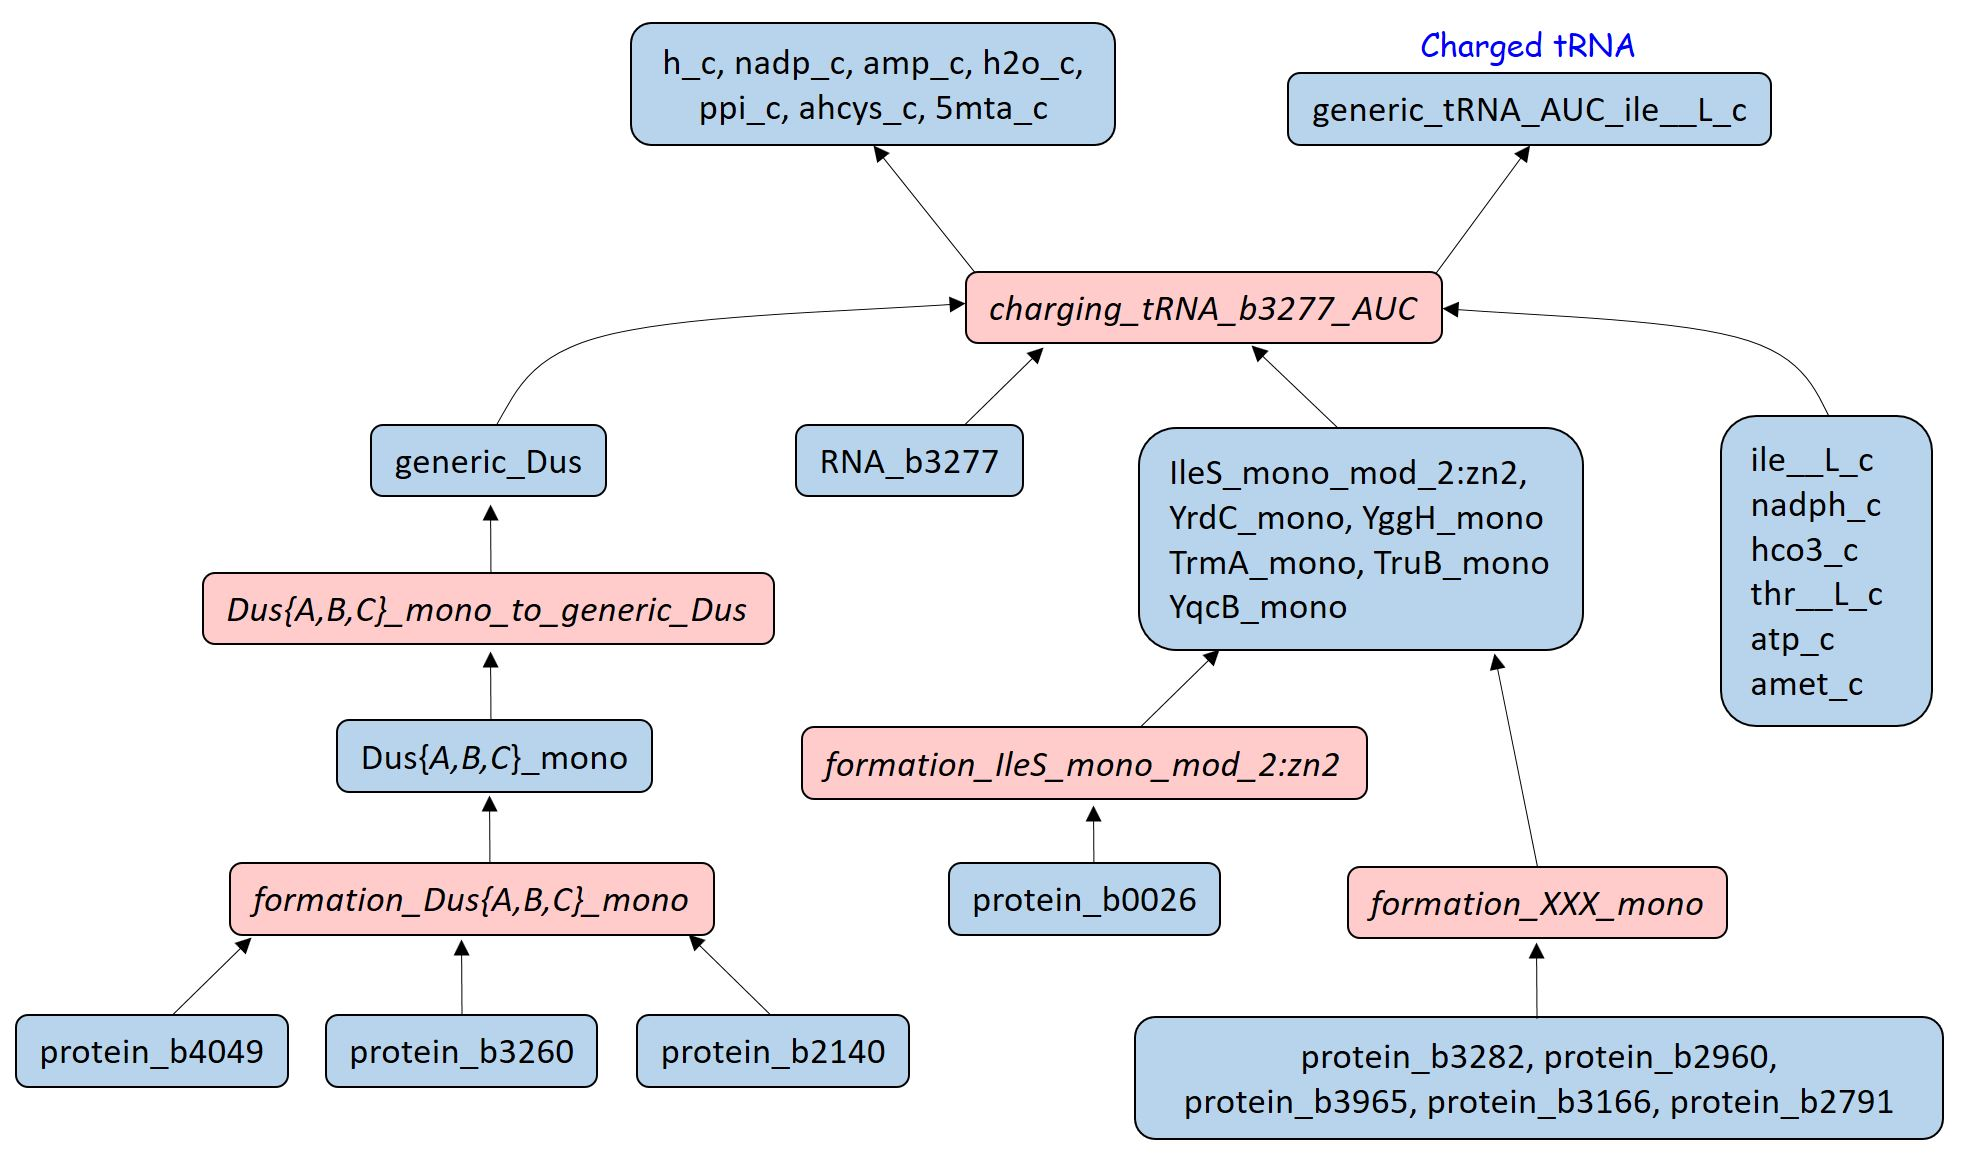

In [26]:
me.process_data.get_by_id('tRNA_b3277_AUC').subreactions

{'D_at_20A': 1,
 'D_at_20': 1,
 't6A_at_37': 1,
 'm7G_at_46': 1,
 'acp3U_at_47': 1,
 'm5U_at_54': 1,
 'Y_at_55': 1,
 'Y_at_65': 1}

In [27]:
me.process_data.get_by_id('D_at_20A').enzyme

['generic_Dus']

In [28]:
me.reactions.get_by_id('charging_tRNA_b3277_AUC').tRNA_data.subreactions

{'D_at_20A': 1,
 'D_at_20': 1,
 't6A_at_37': 1,
 'm7G_at_46': 1,
 'acp3U_at_47': 1,
 'm5U_at_54': 1,
 'Y_at_55': 1,
 'Y_at_65': 1}

In [29]:
dir(me.reactions.get_by_id('charging_tRNA_b3277_AUC').tRNA_data)

['RNA',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_model',
 '_parent_reactions',
 'amino_acid',
 'codon',
 'id',
 'model',
 'parent_reactions',
 'subreactions',
 'synthetase',
 'synthetase_keff',
 'update_parent_reactions']

In [30]:
me.reactions.get_by_id("ACALD_REV_MHPF-MONOMER").id

'ACALD_REV_MHPF-MONOMER'

In [31]:
dir(me.solution)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'dress_results',
 'f',
 'solver',
 'status',
 'x',
 'x_dict',
 'y',
 'y_dict']

In [32]:
dir(me.solution.x_dict)

['__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [33]:
me.solution.x_dict

{'biomass_dilution': 0.828125,
 'protein_biomass_to_biomass': 0.327692839990289,
 'mRNA_biomass_to_biomass': 0.002731281316615861,
 'tRNA_biomass_to_biomass': 0.016582149640663586,
 'rRNA_biomass_to_biomass': 0.11845762085653029,
 'ncRNA_biomass_to_biomass': 0.00018539705088130575,
 'DNA_biomass_to_biomass': 0.023528768749618192,
 'lipid_biomass_to_biomass': 0.11108943229611491,
 'constituent_biomass_to_biomass': 0.021175172347906134,
 'prosthetic_group_biomass_to_biomass': 0.0005762795614813243,
 'peptidoglycan_biomass_to_biomass': 0.02177883569536188,
 'DM_4CRSOL': 2.7233494706766507e-05,
 'DM_5DRIB': 0.00010146754820608403,
 'DM_AACALD': 0.0,
 'DM_AMOB': 5.378783207050113e-07,
 'DM_MTHTHF': 0.004016683709868264,
 'DM_OXAM': 0.0,
 'EX_12ppd__R_e': 0.0,
 'EX_12ppd__S_e': 0.0,
 'EX_14glucan_e': 0.0,
 'EX_15dap_e': 0.0,
 'EX_23camp_e': 0.0,
 'EX_23ccmp_e': 0.0,
 'EX_23cgmp_e': 0.0,
 'EX_23cump_e': 0.0,
 'EX_23dappa_e': 0.0,
 'EX_26dap__M_e': 0.0,
 'EX_2ddglcn_e': 0.0,
 'EX_34dhpac_e': 0

In [34]:
me.solution.f

0.828125

In [35]:
dir(me.solution.x_dict.items)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__text_signature__']

In [36]:
me.reactions.get_by_id('formation_IleS_mono_mod_2:zn2').subsystem

''